# Exercise 3 - Input Scaling and Regularization

In this exercise we want to learn everything about input scaling and apply regularization to a neural network in order to avoid overtraining.
A part of this exercise is taken from [a scikit-learn example](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#results).

# Table of Contents

* [1 Loading the dataset](#Loading-the-dataset)
* [2 Comparison of different input scaling](#Comparison-of-different-input-scaling)
* [3 A DNN for regression](#A-DNN-for-regression)
* [4 Regularization](#Regularization)
    

# Loading the dataset

As in the last exercise we will load tensorflow 2 first and make sure we change our runtime to python 3:


In [12]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Tensorflow version 2.12.0
Python version = 3.11.5


### Task 1: For this exercise we want to use the <a href="http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html">california housing dataset</a> from scikit learn. Prepare the dataset in the following way:
* Load the dataset (`fetch_california_housing`), inspect it and create a pandas `DataFrame` with name `df`.
* What kind of problem is this?
* How many example and how many features do we have? What are the features? What is the target?
* How does the target look like?
* Make 2D scatter plots of all input features, where the color shows the target dependence.
* What do you observe?

*hints*:
- the dataset is part of `sklearn.datasets`
- remember how to `DESCR`ibe a dataset loaded this way
- remember the `scatter_matrix`

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


#Load the dataset
housing = fetch_california_housing()
print(housing['DESCR'])
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## What kind of problem is this?

This is a regression problem as we try to predict the house value based on different variables.

## How many examples and how many features do we have? What are the features? What is the target?

"The dataset consists of *20,640* observations (examples) on *9* variables (features) [...].":

* median income in block group
* median house age in block group
* average number of rooms per household
* average number of bedrooms per household
* block group population
* average number of household members
* block group latitude
* block group longitude

As we try to predict the value of the different houses this is our target.

In [14]:
print(housing.target, housing.target.shape, np.min(housing.target), np.max(housing.target))

[4.526 3.585 3.521 ... 0.923 0.847 0.894] (20640,) 0.14999 5.00001


# Comparison of different input scaling

In [15]:
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


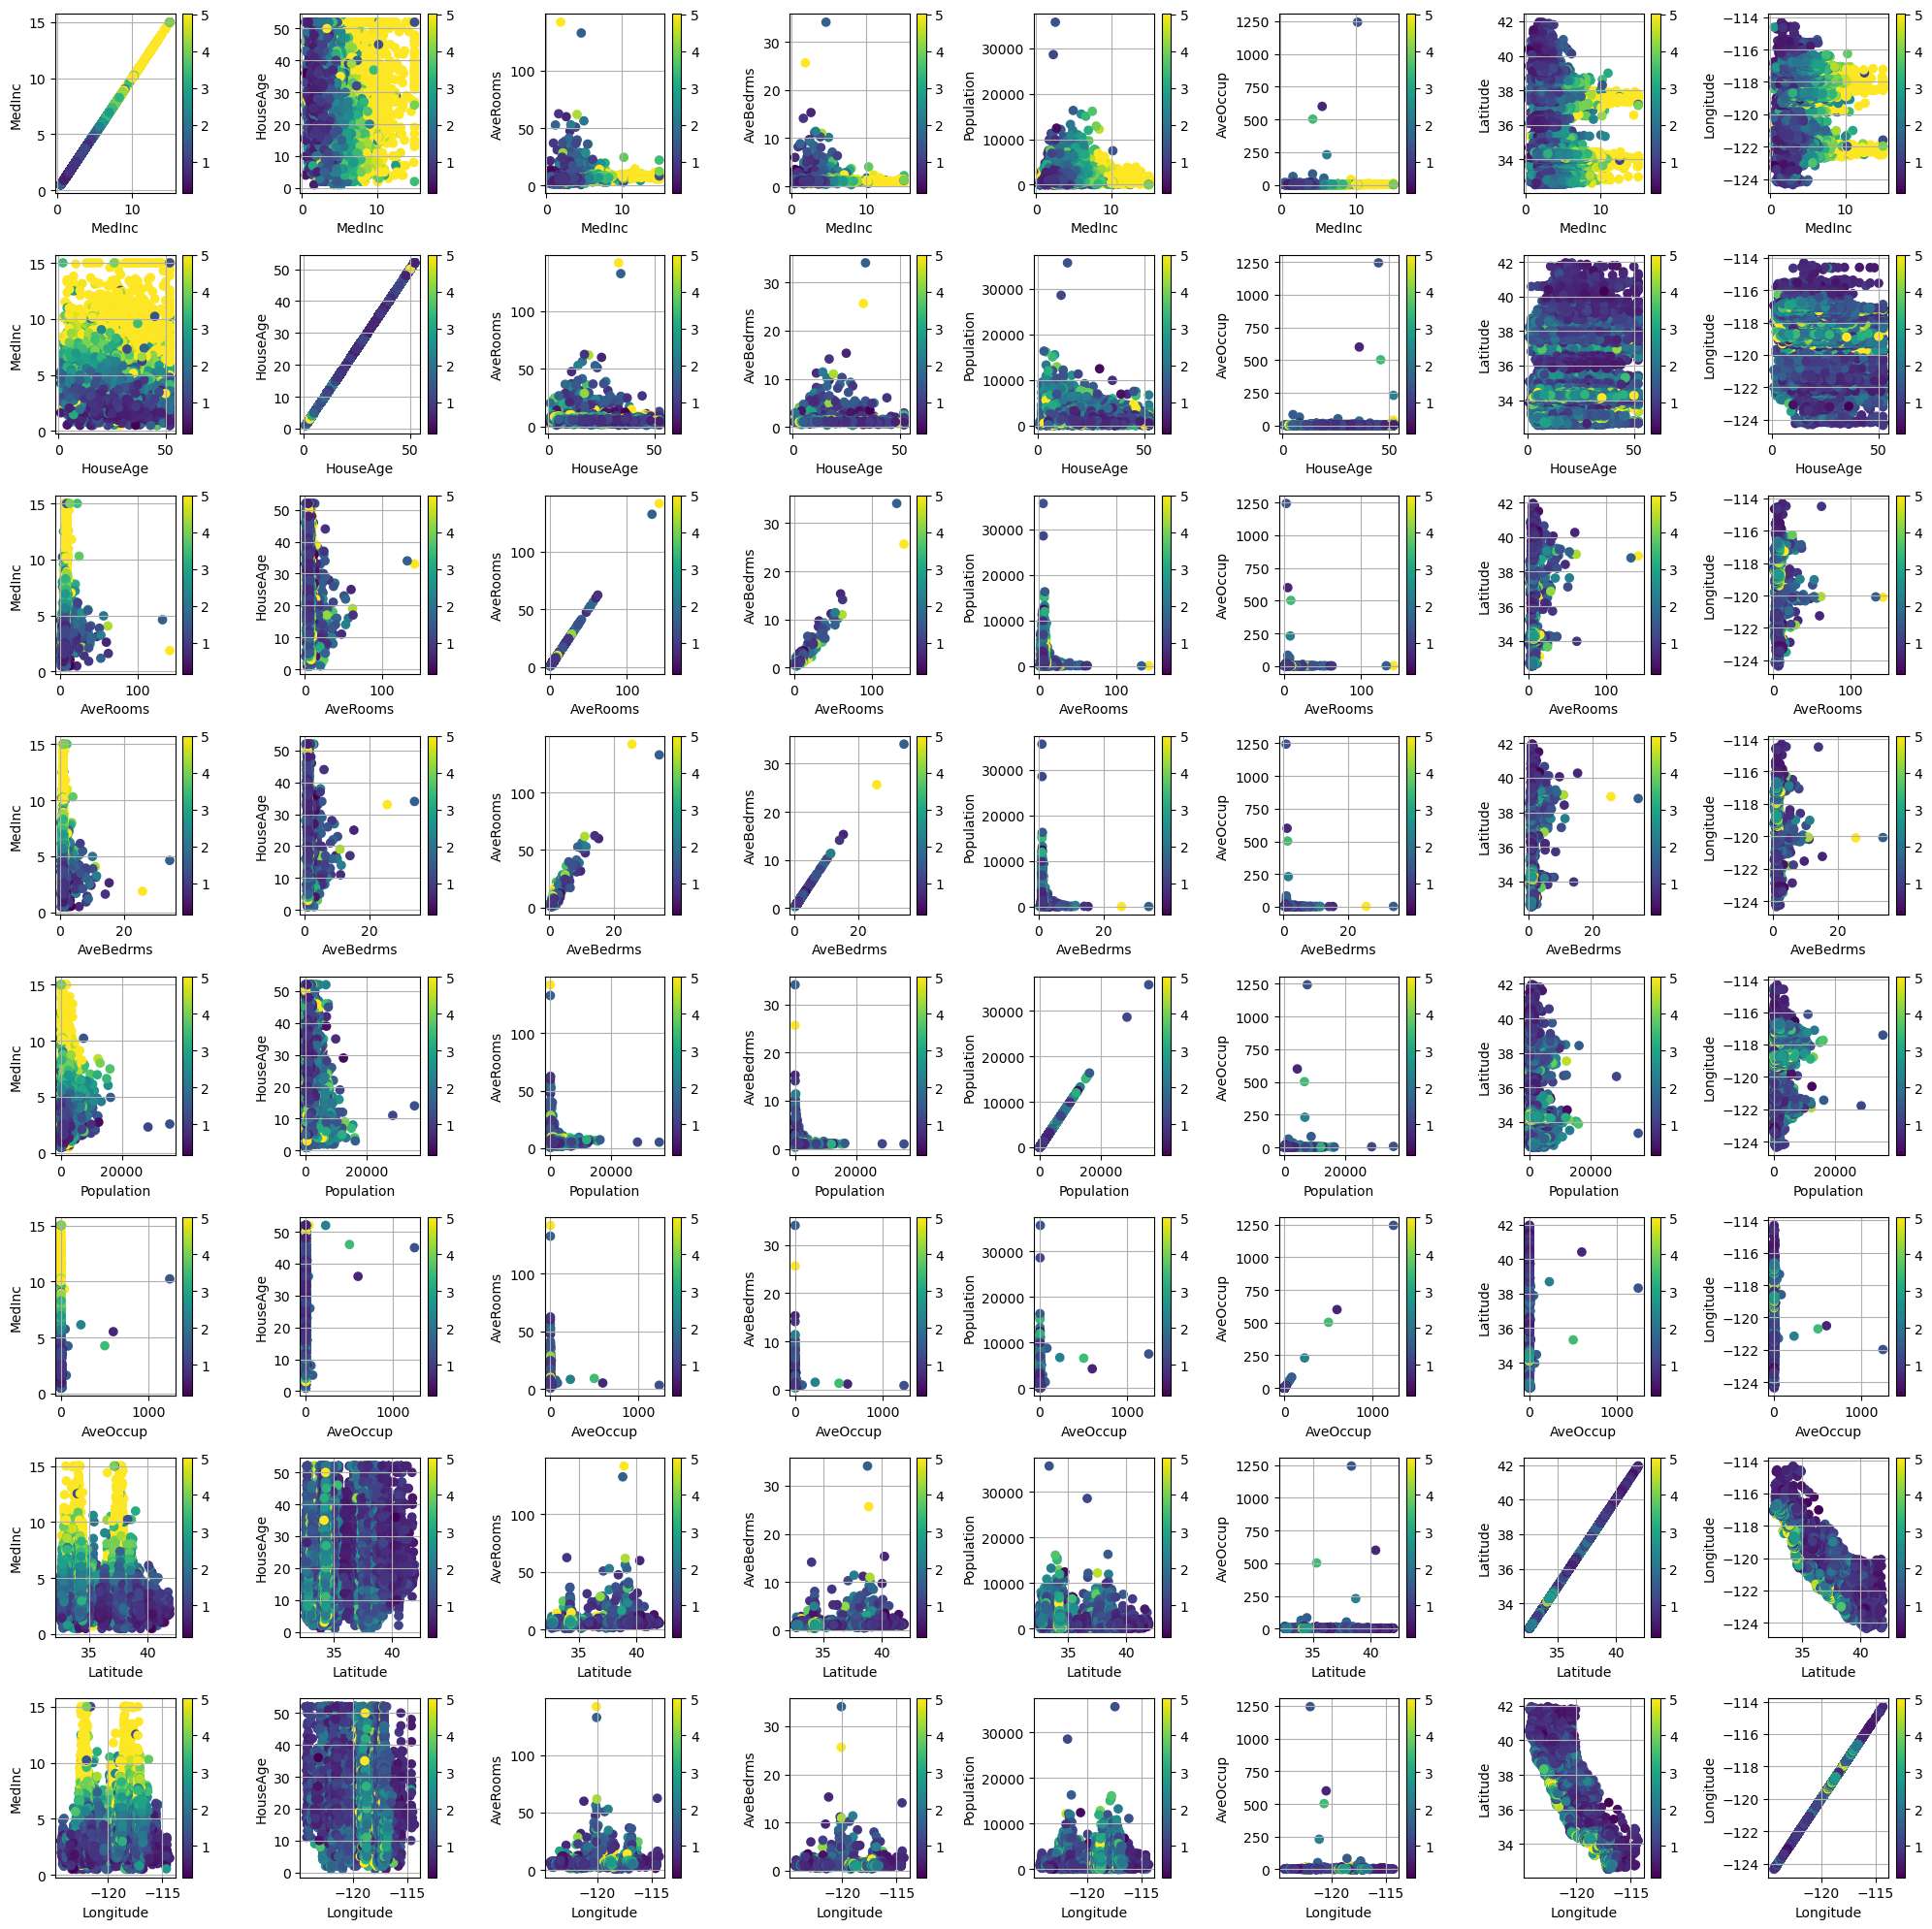

In [16]:
import matplotlib.pyplot as plt

yName = np.array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])


fig, axs = plt.subplots(8, 8, figsize=(20, 20))

axs = axs.ravel()

k = 0
for i in range(8):
        for j in range(8):
            axs[k].scatter(df[yName[i]], df[yName[j]], c=housing.target)
            axs[k].set_xlabel(yName[i])
            axs[k].set_ylabel(yName[j])
            colorbar = fig.colorbar(axs[k].collections[0], ax=axs[k], orientation='vertical')
            axs[k].grid()
            k += 1

fig.tight_layout()

Feature 0 (median income in a block) and feature 5 (number of households) of the California housing dataset
have very different scales and contain some very large outliers. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.

Indeed many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based and gradient-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

This example uses different scalers, transformers, and normalizers to bring the data within a pre-defined range.

Scalers are linear (or more precisely affine) transformers and differ from each other in the way to estimate the parameters used to shift and scale each feature.

QuantileTransformer provides a non-linear transformation in which distances between marginal outliers and inliers are shrunk.

Unlike the previous transformations, normalization refers to a per sample transformation instead of a per feature transformation.

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

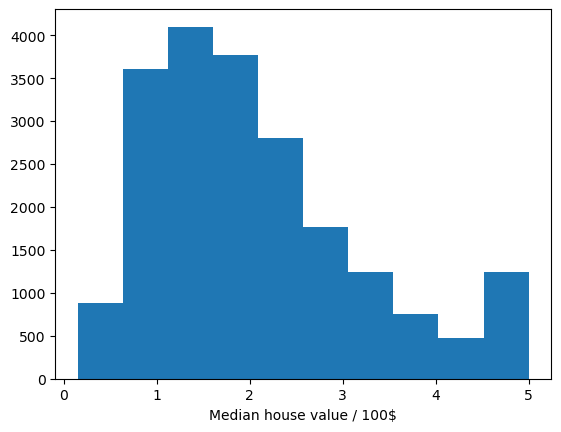

In [60]:
plt.hist(housing.target)
plt.xlabel('Median house value / 100$')
housing.target

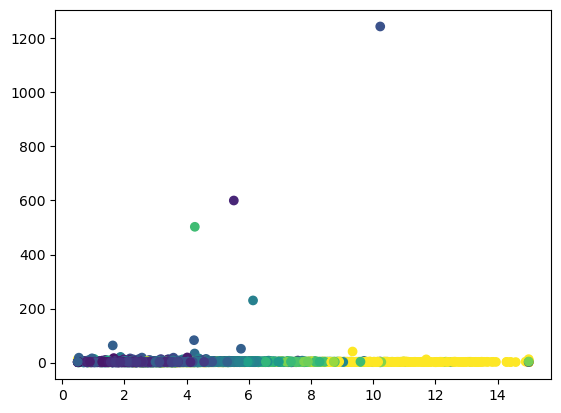

In [62]:
plt.scatter(df['MedInc'], df['AveOccup'], c=housing.target)
plt.show()

## Scaling the target

It often makes sense to scale the target of a regression to something between 0 and 1, because that way you can use activation functions in the output layer which map to that range.
If you use functions like sigmoid in the output layer, this keeps the backpropagated error within limits, unlike the case of unbounded linear activation functions. You could even scale to ranges like [0.3, 0.7] in order to focus on the almost linear-part of the sigmoid function.
In the following we will scale the target between 0 and 1 also for plotting reasons. We will use the minmax_scale for that

In [18]:
from sklearn.preprocessing import minmax_scale
y_full=housing.target
y = minmax_scale(y_full, feature_range=(0, 1))
y

array([0.90226638, 0.70824656, 0.69505074, ..., 0.15938285, 0.14371281,
       0.15340349])

## Scaling the input

We will focus in the following on the median income [0] and number of households [5] scatter plot and how different scalings impact their range.

In [19]:
X = housing.data[:, [0, 5]]

In the following, We have taken the scaling and plotting code from  [the scikit-learn example mentioned earlier](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#results).

You don't need to understand how the scaling and plotting is done for now, but the purpose is mainly to demonstrate how different scalers impact your input

In [20]:
# Author:  Raghav RV <rvraghav93@gmail.com>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Thomas Unterthiner
# License: BSD 3 clause

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X))
]

In [21]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cm.plasma_r(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

Two plots will be shown for each scaler/normalizer/transformer. The left figure will show a scatter plot of the full data set while the right figure will exclude the extreme values considering only 99 % of the data set, excluding marginal outliers. In addition, the marginal distributions for each feature will be shown on the side of the scatter plot.



In [22]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label="Median Income",
                      x1_label="Number of households",
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="Median Income",
                      x1_label="Number of households",
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cm.plasma_r,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')


Original data
-------------

Each transformation is plotted showing two transformed features, with the
left plot showing the entire dataset, and the right zoomed-in to show the
dataset without the marginal outliers. A large majority of the samples are
compacted to a specific range, [0, 10] for the median income and [0, 6] for
the number of households. Note that there are some marginal outliers (some
blocks have more than 1200 households). Therefore, a specific pre-processing
can be very beneficial depending of the application. In the following, we
present some insights and behaviors of those pre-processing methods in the
presence of marginal outliers.



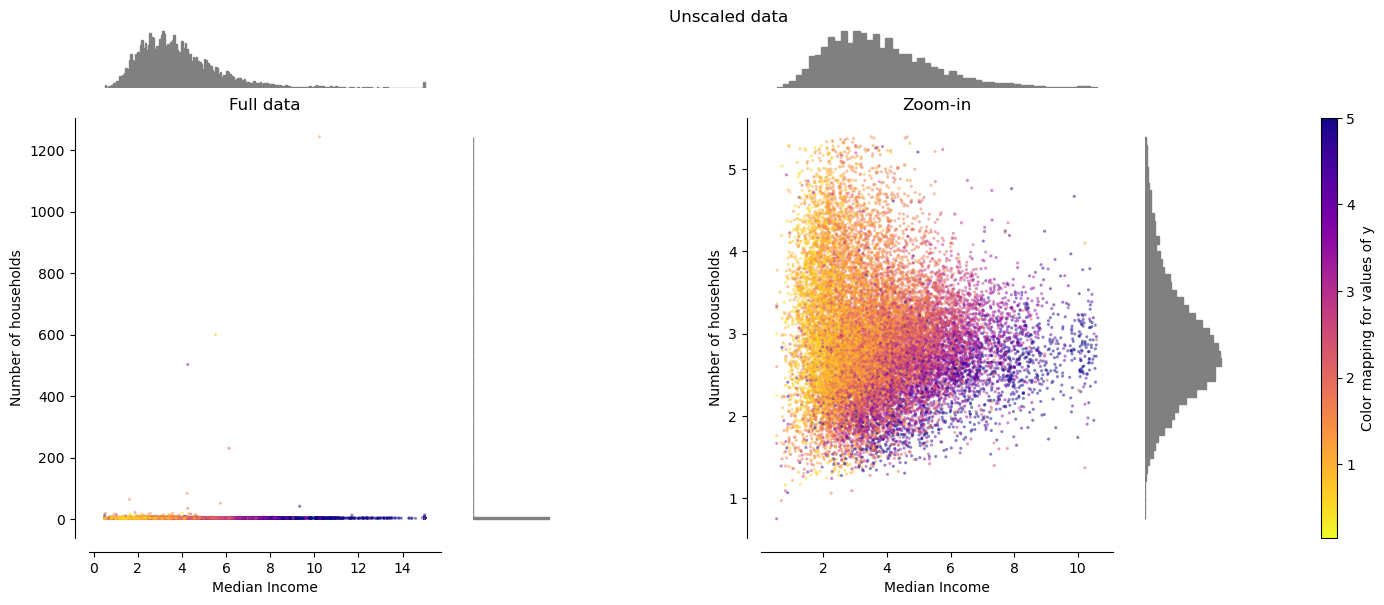

In [23]:
make_plot(0)

StandardScaler
--------------

``StandardScaler`` removes the mean (0) and scales the data to unit variance (1).
However, the outliers have an influence when computing the empirical mean and
standard deviation which shrink the range of the feature values as shown in
the left figure below. Note in particular that because the outliers on each
feature have different magnitudes, the spread of the transformed data on
each feature is very different: most of the data lie in the [-2, 4] range for
the transformed median income feature while the same data is squeezed in the
smaller [-0.2, 0.2] range for the transformed number of households.

``StandardScaler`` therefore cannot guarantee balanced feature scales in the
presence of outliers.



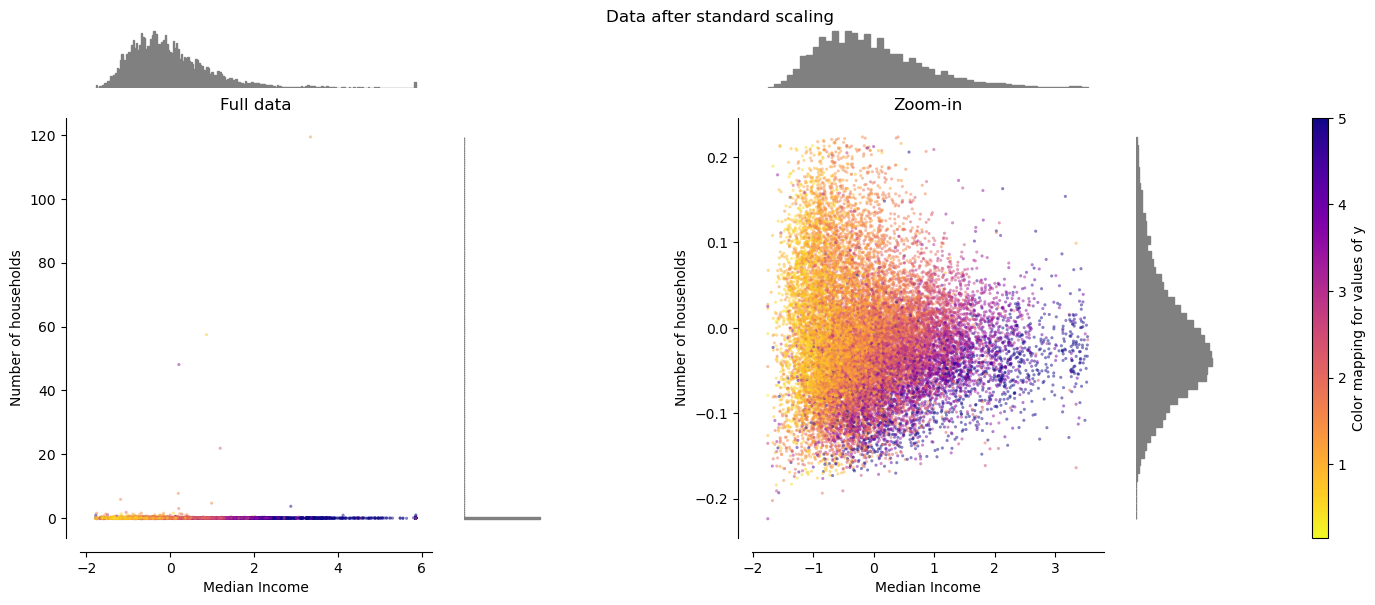

In [24]:
make_plot(1)

MinMaxScaler
------------

``MinMaxScaler`` rescales the data set such that all feature values are in
the range [0, 1] as shown in the right panel below. However, this scaling
compress all inliers in the narrow range [0, 0.005] for the transformed
number of households.

As ``StandardScaler``, ``MinMaxScaler`` is very sensitive to the presence of
outliers.



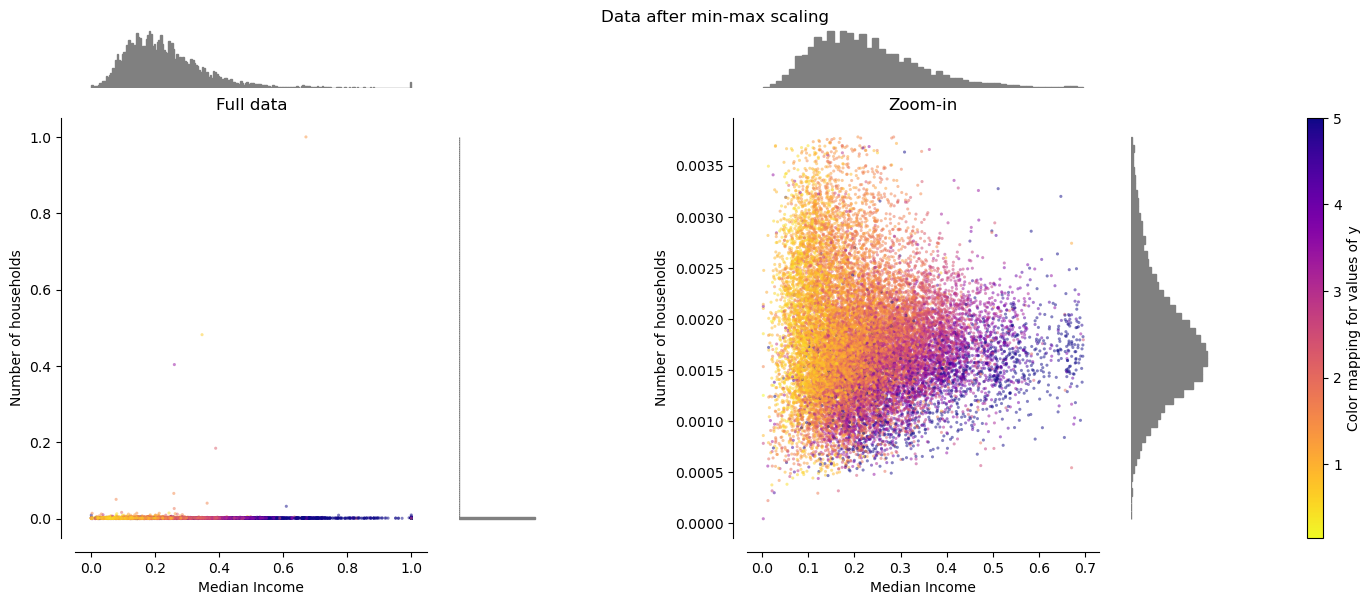

In [25]:
make_plot(2)

MaxAbsScaler
------------

``MaxAbsScaler`` differs from the previous scaler such that the absolute
values are mapped in the range [0, 1]. On positive only data, this scaler
behaves similarly to ``MinMaxScaler`` and therefore also suffers from the
presence of large outliers.



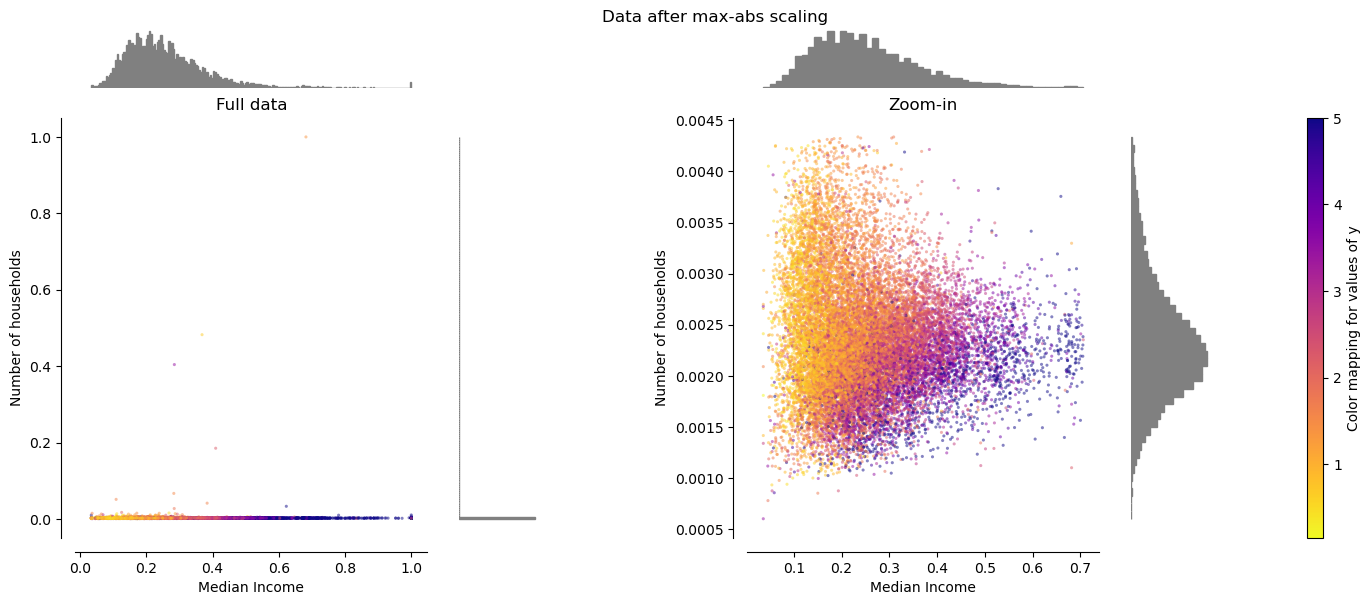

In [26]:
make_plot(3)

RobustScaler
------------

Unlike the previous scalers, the centering and scaling statistics of this
scaler are based on percentiles and are therefore not influenced by a small
number of very large marginal outliers. Consequently, the resulting range of
the transformed feature values is larger than for the previous scalers and,
more importantly, are approximately similar: for both features most of the
transformed values lie in a [-2, 3] range as seen in the zoomed-in figure.
Note that the outliers themselves are still present in the transformed data.
If a separate outlier clipping is desirable, a non-linear transformation is
required (see below).



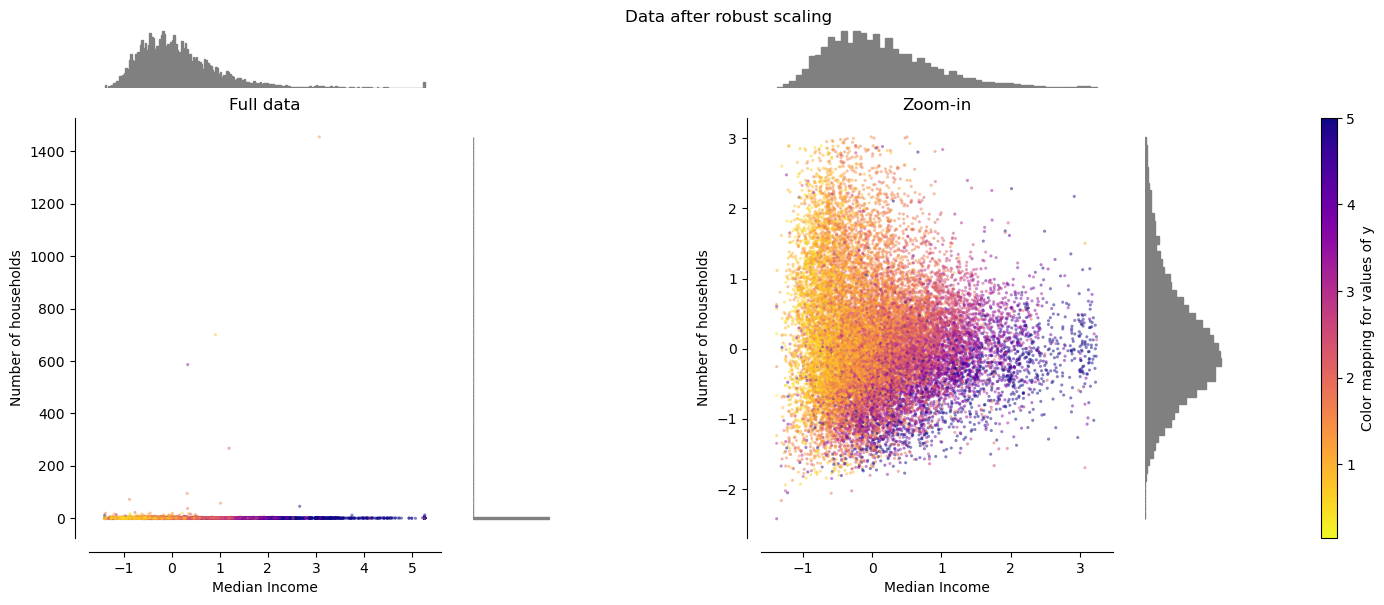

In [27]:
make_plot(4)

QuantileTransformer (uniform output)
------------------------------------

``QuantileTransformer`` applies a non-linear transformation such that the
probability density function of each feature will be mapped to a uniform
distribution. In this case, all the data will be mapped in the range [0, 1],
even the outliers which cannot be distinguished anymore from the inliers.

As ``RobustScaler``, ``QuantileTransformer`` is robust to outliers in the
sense that adding or removing outliers in the training set will yield
approximately the same transformation on held out data. But contrary to
``RobustScaler``, ``QuantileTransformer`` will also automatically collapse
any outlier by setting them to the a priori defined range boundaries (0 and
1).



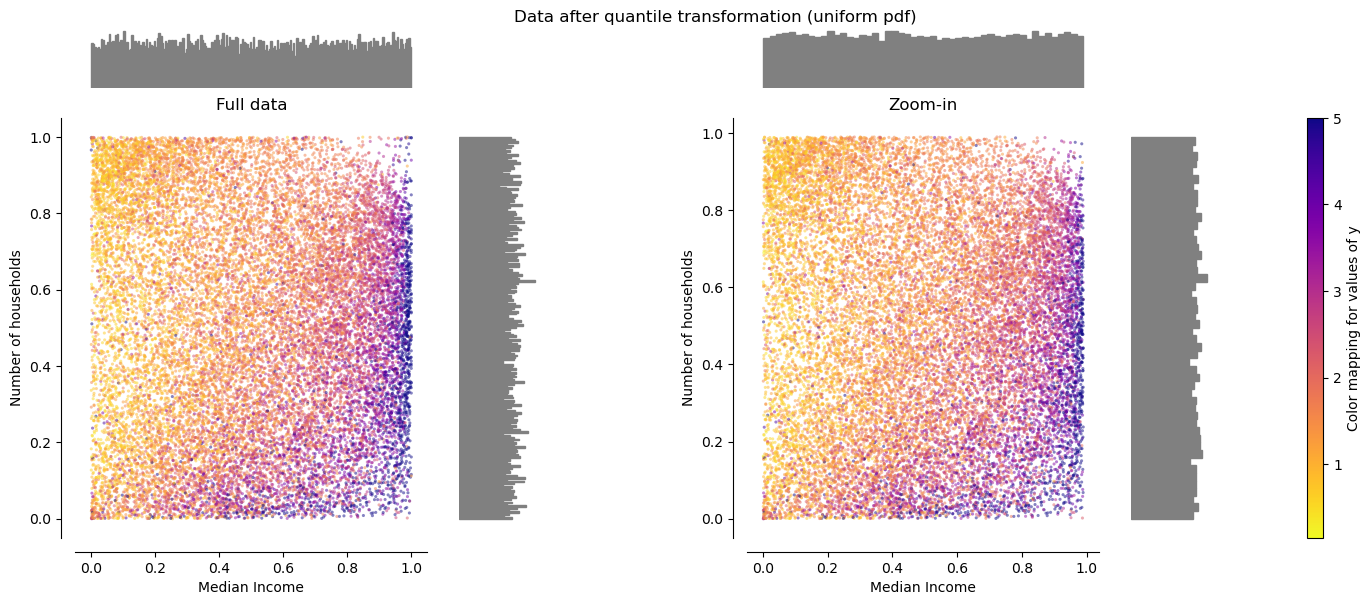

In [28]:
make_plot(5)

QuantileTransformer (Gaussian output)
-------------------------------------

``QuantileTransformer`` has an additional ``output_distribution`` parameter
allowing to match a Gaussian distribution instead of a uniform distribution.
Note that this non-parametetric transformer introduces saturation artifacts
for extreme values.



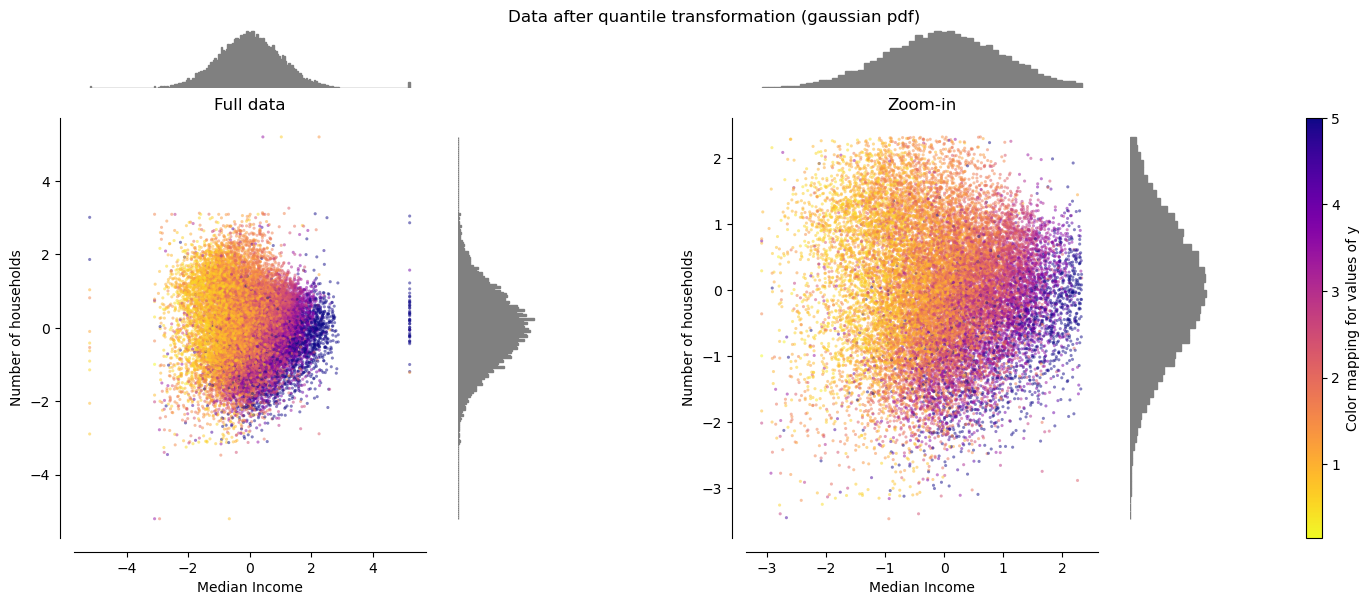

In [29]:
make_plot(6)

Normalizer
----------

The ``Normalizer`` rescales the vector for each sample to have unit norm,
independently of the distribution of the samples. It can be seen on both
figures below where all samples are mapped onto the unit circle. In our
example the two selected features have only positive values; therefore the
transformed data only lie in the positive quadrant. This would not be the
case if some original features had a mix of positive and negative values.



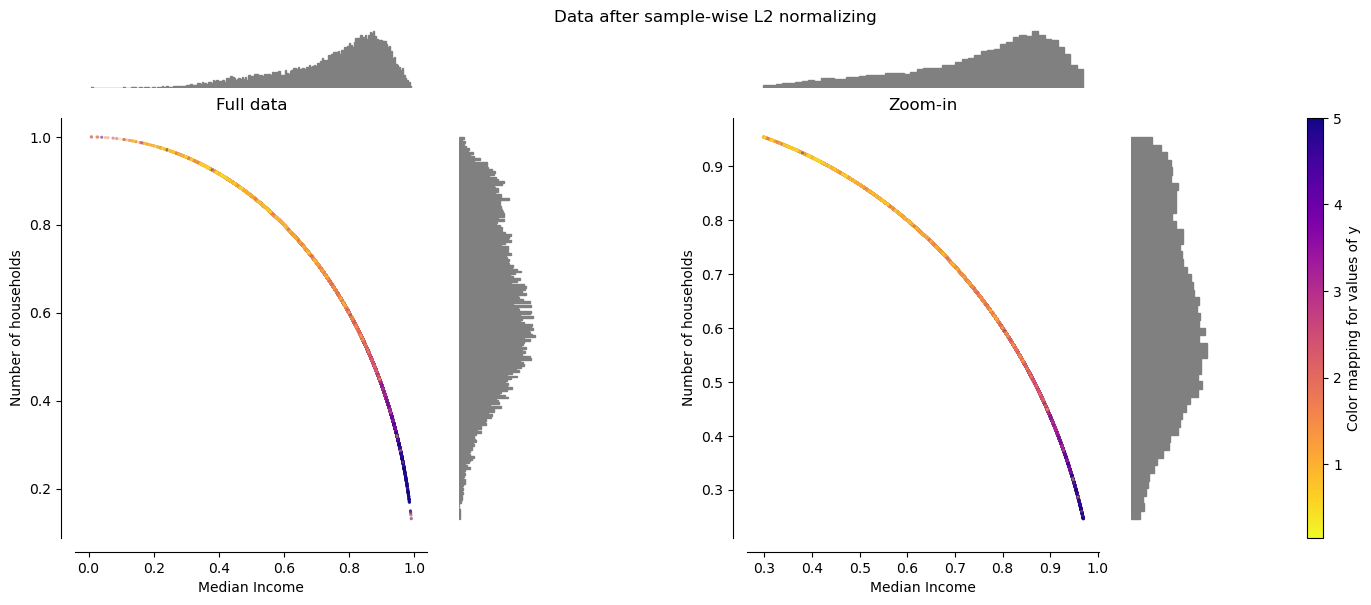

In [30]:
make_plot(7)
plt.show()

## Which scaler should we use?

Let's have a closer look at the robust scaler on our entire dataset:

In [31]:
df_robust = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(df), columns=housing.feature_names)
df_robust.head(10)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.197582  0.631579  1.088935  -0.267221   -0.899787 -0.307981  0.957672   
1  2.186664 -0.421053  0.626066  -0.822926    1.316631 -0.830800  0.952381   
2  1.707732  1.210526  1.898042   0.263955   -0.714286 -0.018599  0.949735   
3  0.967177  1.210526  0.364978   0.259814   -0.648188 -0.316908  0.949735   
4  0.142854  1.210526  0.653191   0.345657   -0.640725 -0.746784  0.949735   
5  0.230291  1.210526 -0.290055   0.586926   -0.802772 -0.795547  0.949735   
6  0.057022  1.210526 -0.184419  -1.042501   -0.076759 -0.809026  0.947090   
7 -0.190288  1.210526 -0.267799   0.139580   -0.009595 -1.208021  0.947090   
8 -0.667202  0.684211 -0.580152   0.736958    0.042644 -0.928102  0.947090   
9  0.071748  1.210526 -0.160418  -0.626926    0.410448 -0.757574  0.947090   

   Longitude  
0  -0.986807  
1  -0.984169  
2  -0.989446  
3  -0.992084  
4  -0.992084  
5  -0.992084  
6  -0.992084  
7  -0.992084  
8  -0.994723  
9  -0.992084

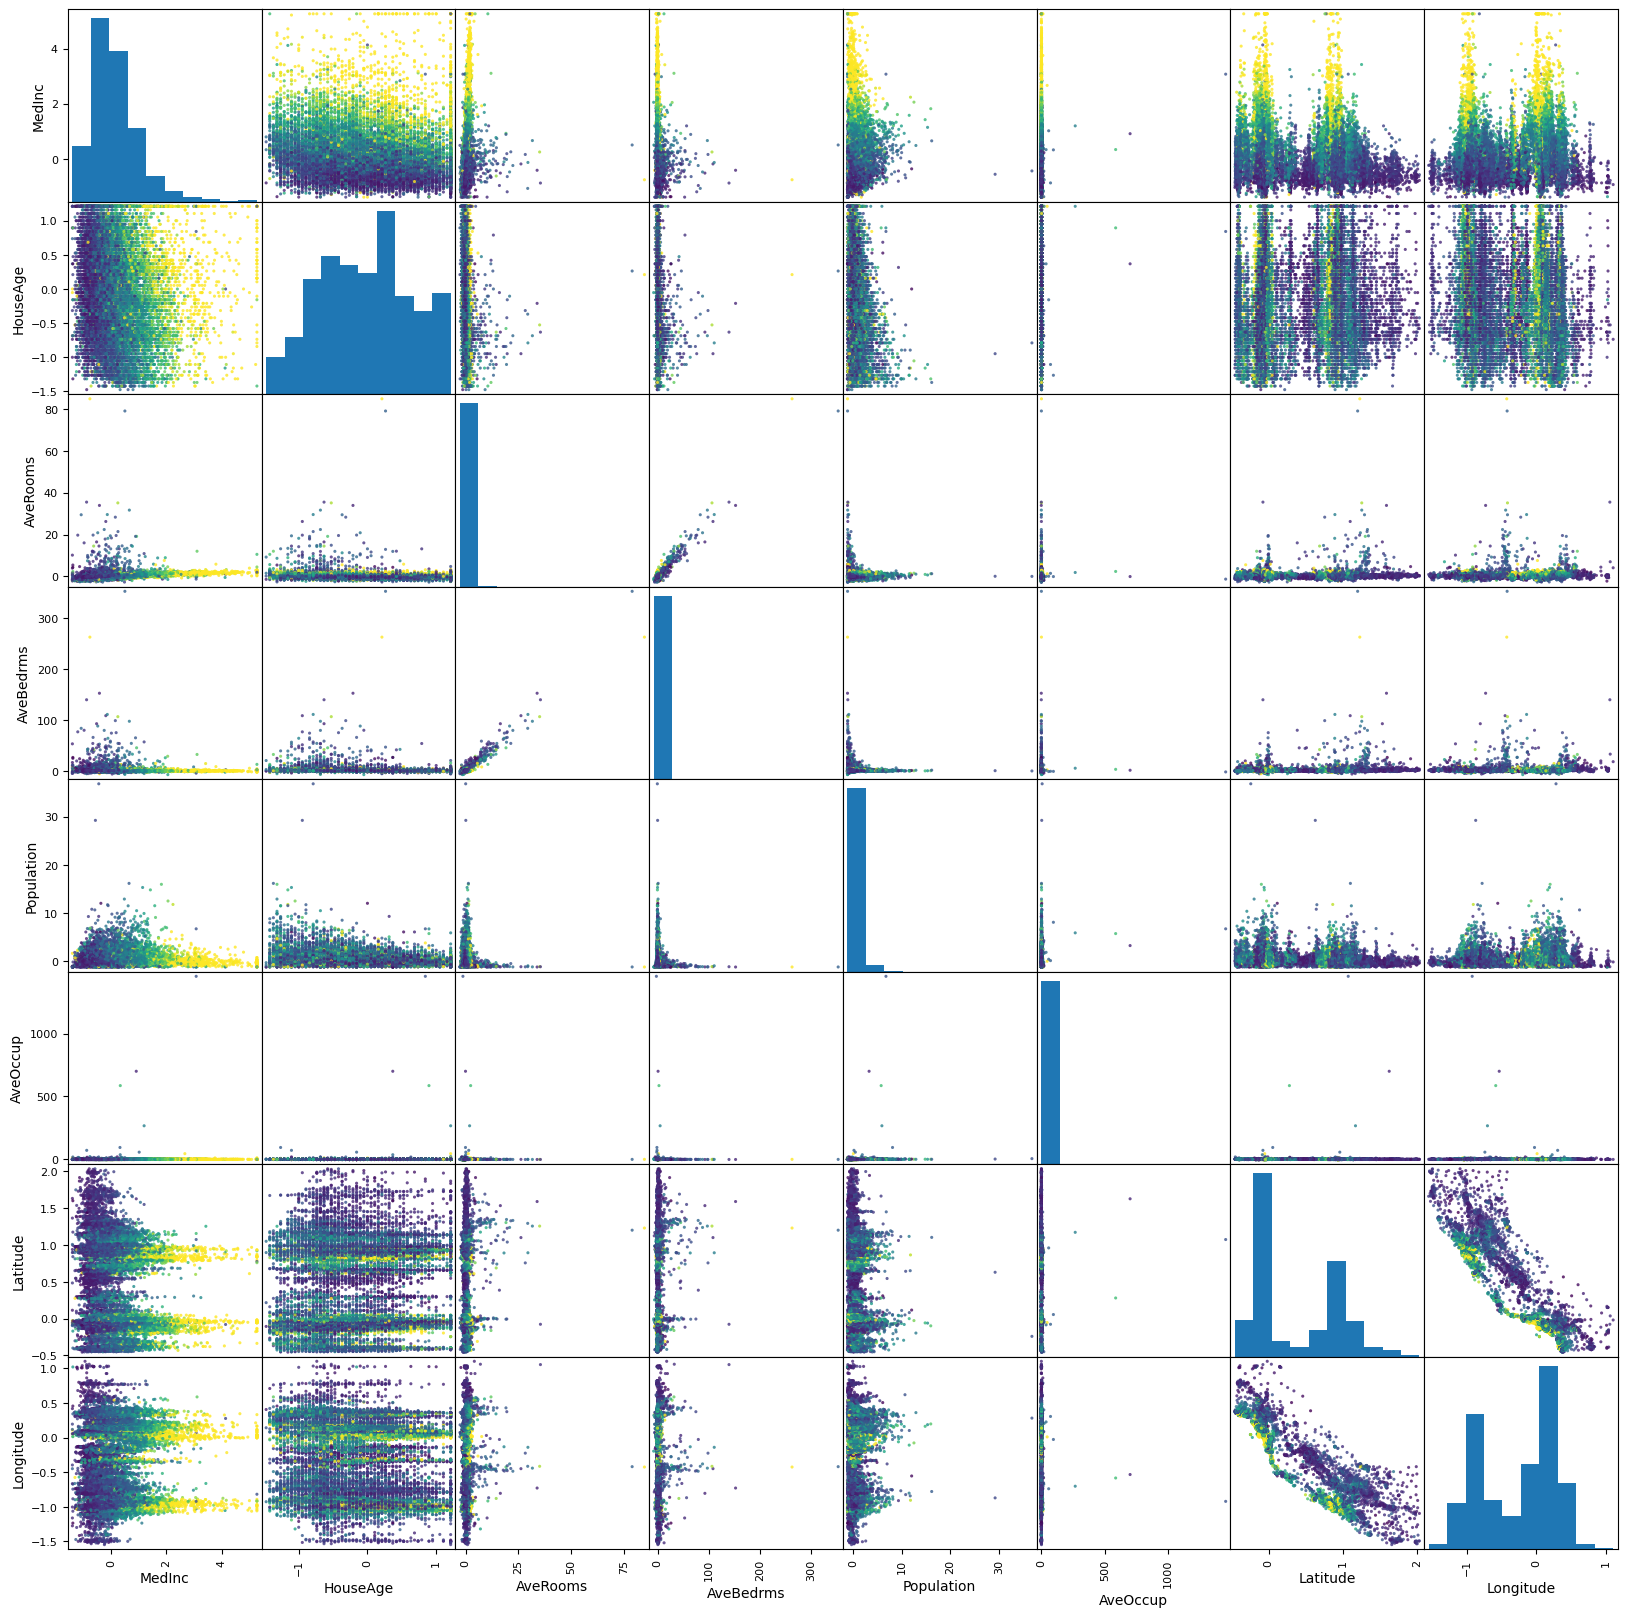

In [32]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_robust, c=housing.target, alpha=0.8, figsize=(20, 20), s=20)
plt.show()

What about the non-linear gaussian transformation, if gaussian distributed shapes are ideal for most machine learning algorithms

In [33]:
df_gauss = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(df), columns=housing.feature_names)
df_gauss.head(10)


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  1.915911  0.912774  1.280936  -0.388572   -1.696684 -0.456473  0.899534   
1  1.911668 -0.476619  0.810434  -1.205375    1.178392 -1.225523  0.882739   
2  1.625522  5.199338  1.926863   0.360223   -1.311992 -0.031507  0.875354   
3  1.094753  5.199338  0.496122   0.355349   -1.171997 -0.470312  0.875354   
4  0.190117  5.199338  0.837769   0.463423   -1.162798 -1.107300  0.875354   
5  0.298061  5.199338 -0.403205   0.727744   -1.496723 -1.177451  0.875354   
6  0.087101  5.199338 -0.251343  -1.493055   -0.132113 -1.194168  0.868016   
7 -0.260119  5.199338 -0.369144   0.204051   -0.029572 -1.803266  0.868016   
8 -1.097087  0.975466 -0.801756   0.858910    0.045598 -1.357367  0.868016   
9  0.110898  5.199338 -0.217968  -0.930036    0.482617 -1.123600  0.868016   

   Longitude  
0  -1.140077  
1  -1.128144  
2  -1.157061  
3  -1.179402  
4  -1.179402  
5  -1.179402  
6  -1.179402  
7  -1.179402  
8  -1.204935  
9  -1.179402

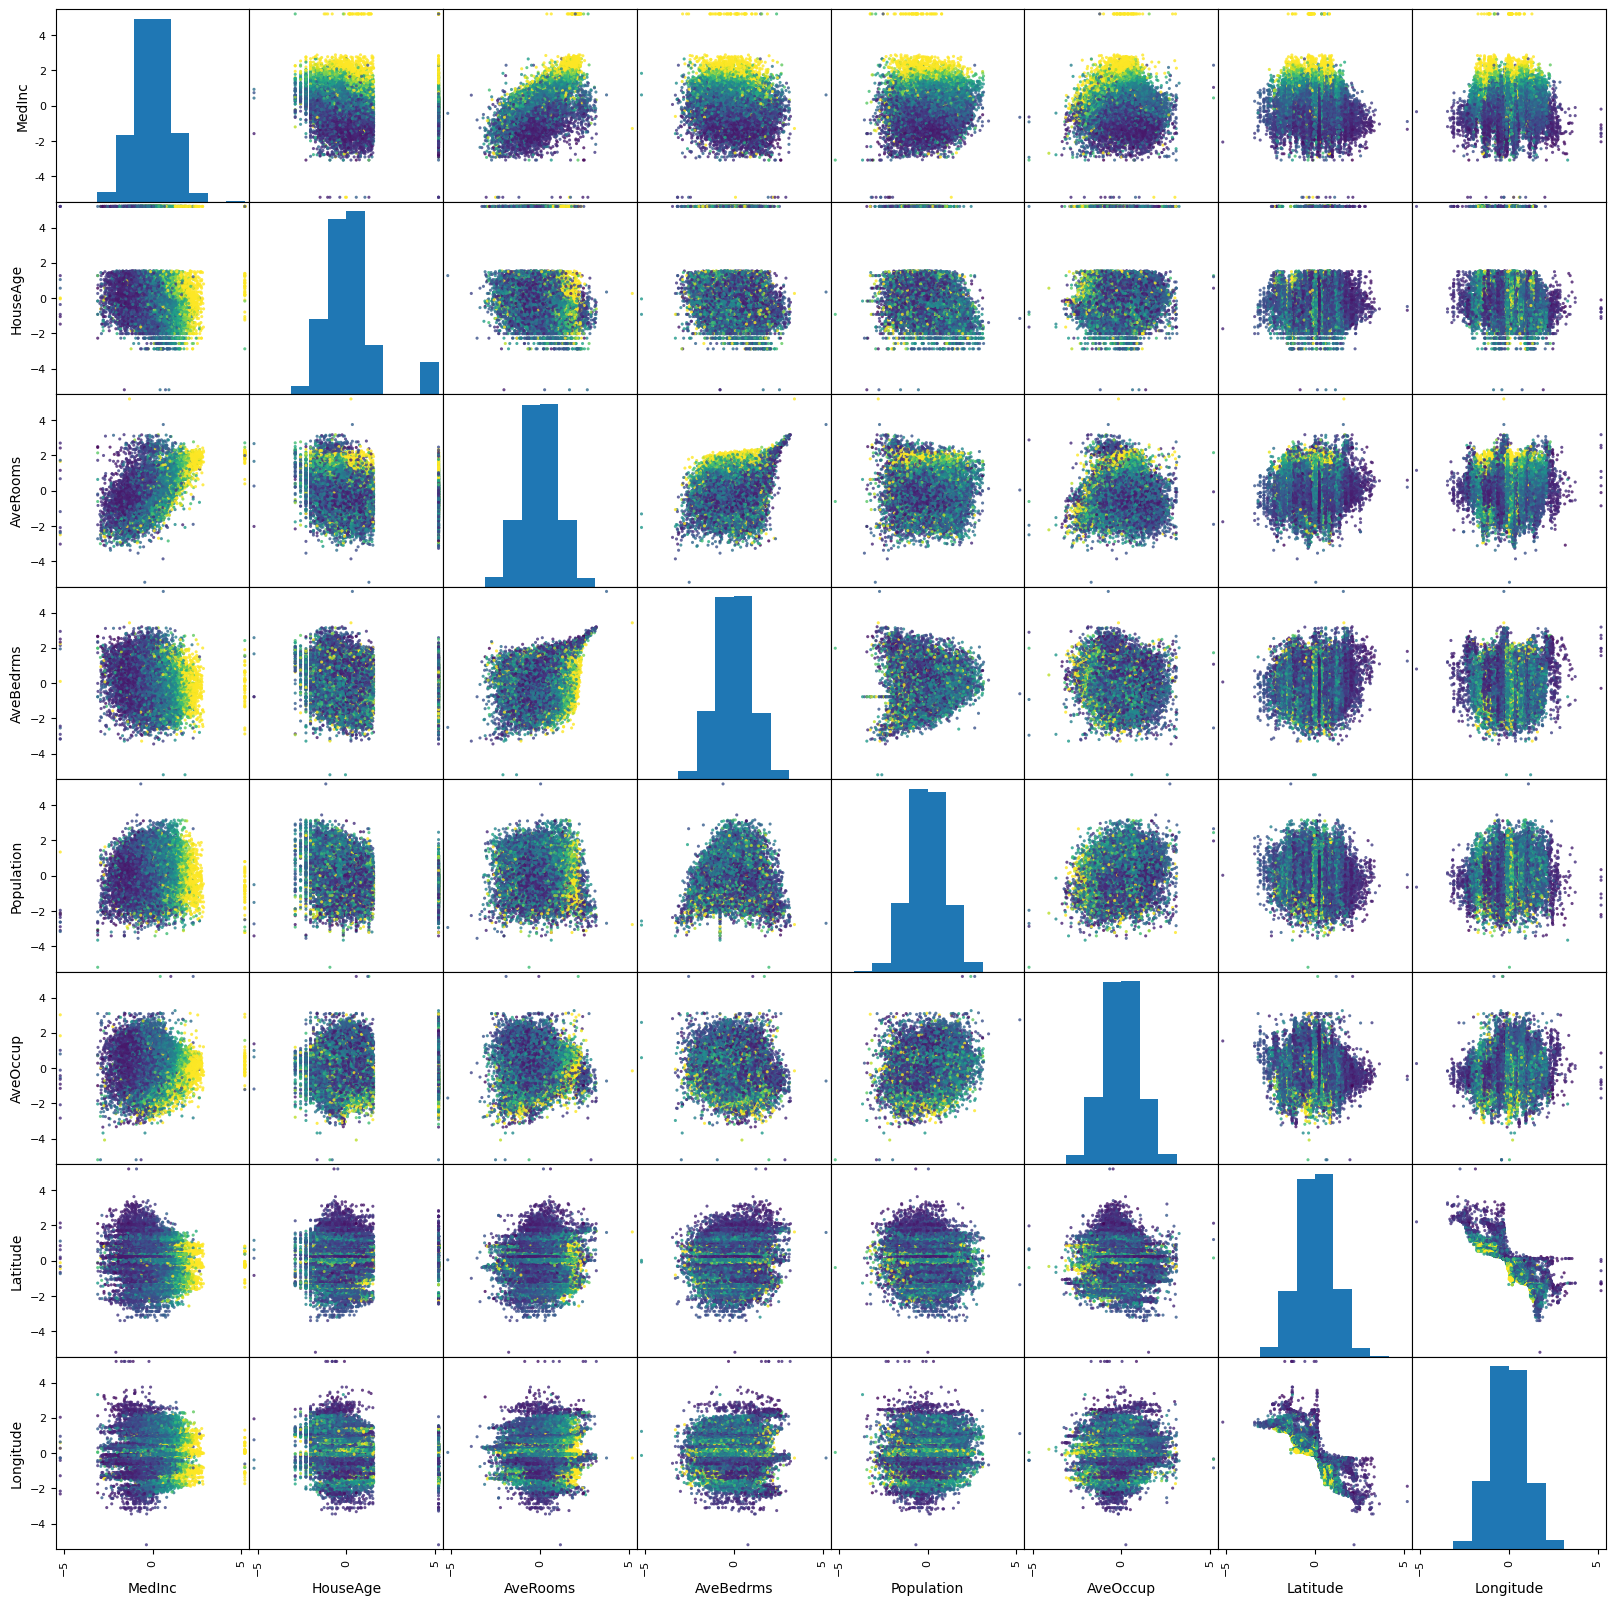

In [34]:
scatter_matrix(df_gauss, c=housing.target, alpha=0.8, figsize=(20, 20), s=20)
plt.show()

## Impact on the correlations

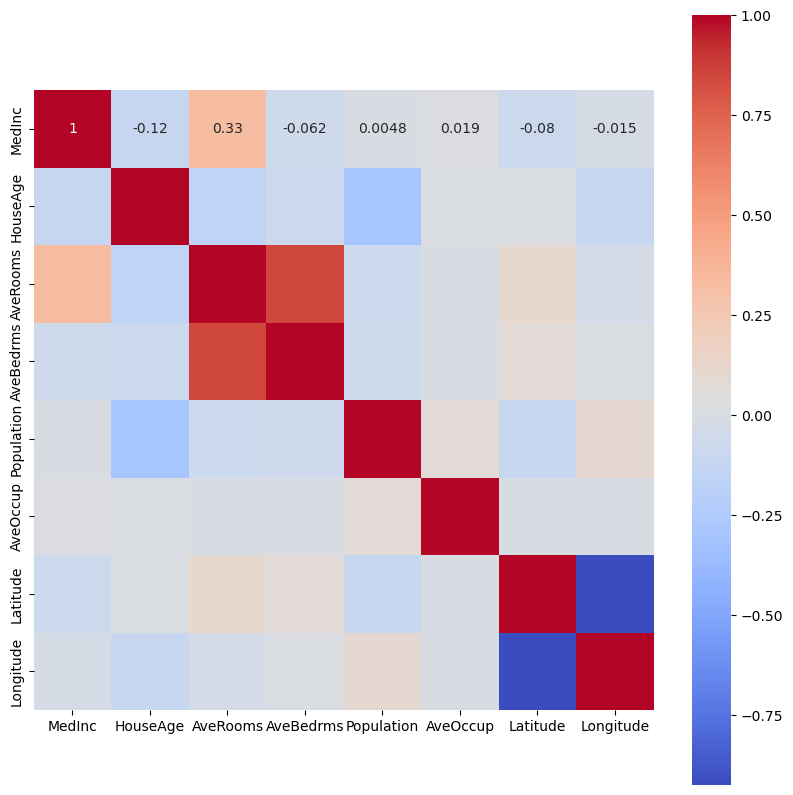

In [35]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

<Axes: >

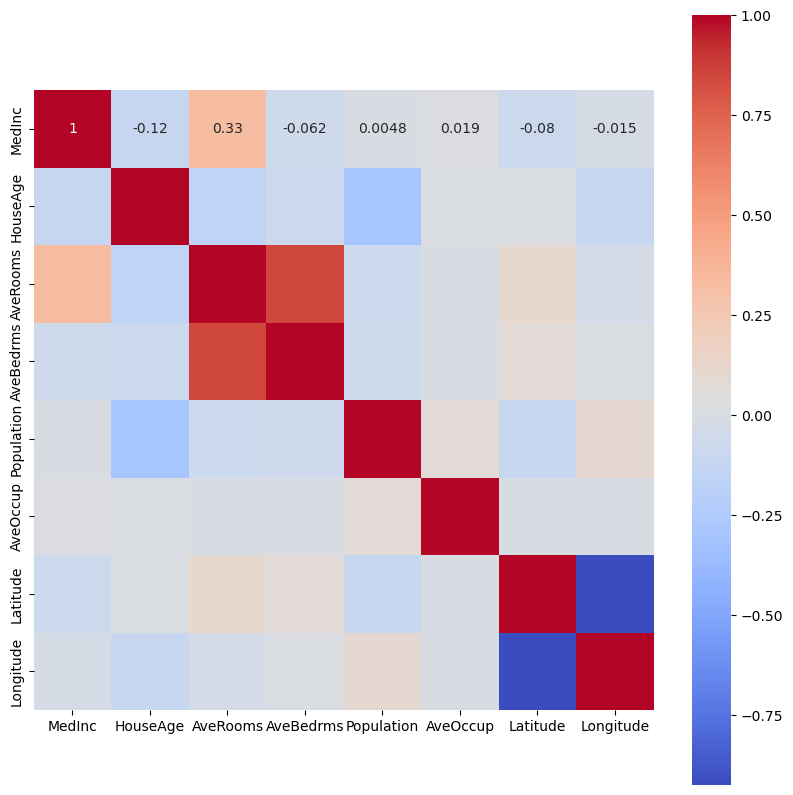

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(df_robust.corr(), annot=True, square=True, cmap='coolwarm')

<Axes: >

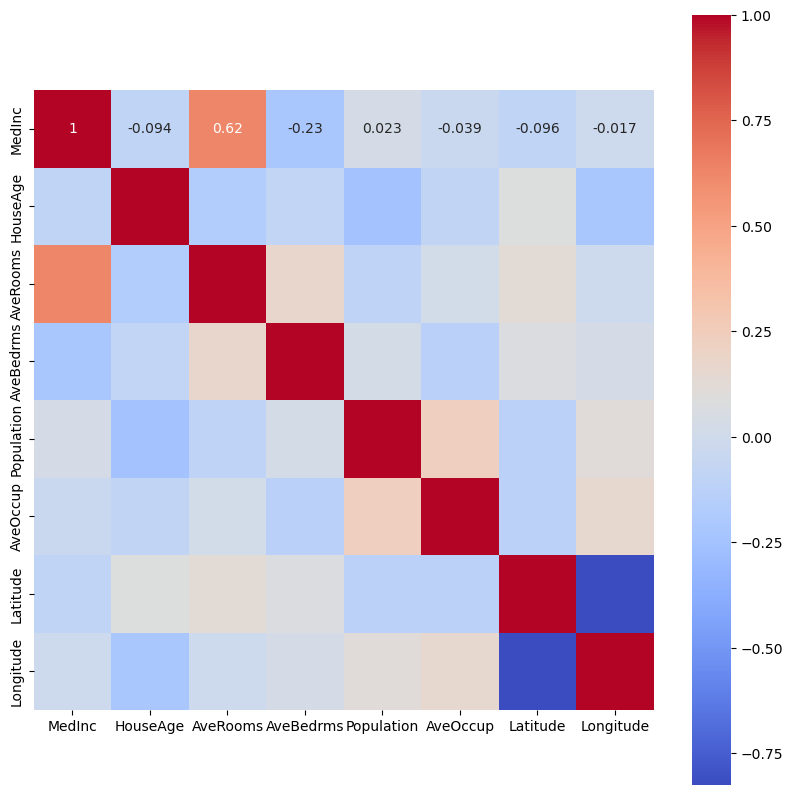

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(df_gauss.corr(), annot=True, square=True, cmap='coolwarm')

Non-linear transformations smooth out distributions and are less influenced by outliers. However, they distort correlations and distances within and across features. There is no general answer, which scaler will work best for the problem. Like many things in machine learning, this is simply something one need to test/study.

# A DNN for regression

### Task 2: Design a DNN for this regression problem
* Prepare the data by creating a robust scaled design matrix and a minmax scaled target vector and split into training (70%) and test sample.
* Design a simple fully-connected DNN for regression with 4 hidden layers. Make sure that the capacity is large enough that you see clear overtraining. Use 30% of the training data for validation. Use `adam` as optimizer and set the batch size to 256.
* What is a good activation function for the output node? What is a good loss function?
* Train the DNN over 300 epochs and plot the loss function and one additional metric for linear regression as a function of epochs.
* Evaluate the obtained model on the testing data, compare the prediction to the true value.
* Compare the results on the training and on the test data. How can you investigate overtraining? How can you quantify it?
* Use scikit-learn metrics for regression to evaluate the model
* Which feature has the highest linear correlation to the prediction? Plot the true value and the prediction dependent on this feature.

*hints*:

- split first, scale second

In [63]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.values, housing.target, test_size=0.3, random_state=42)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

In [88]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=8))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
loss=tf.keras.losses.MeanSquaredError()
metrics=['mse', 'mae']


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [89]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=300, batch_size=256)

Epoch 1/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1145 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0938
Epoch 2/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0899 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0923
Epoch 3/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0881 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0873
Epoch 4/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0848 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0869
Epoch 5/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0831 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0831
Epoch 6/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0814 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0852
Epoch 7/300
40/40 [===

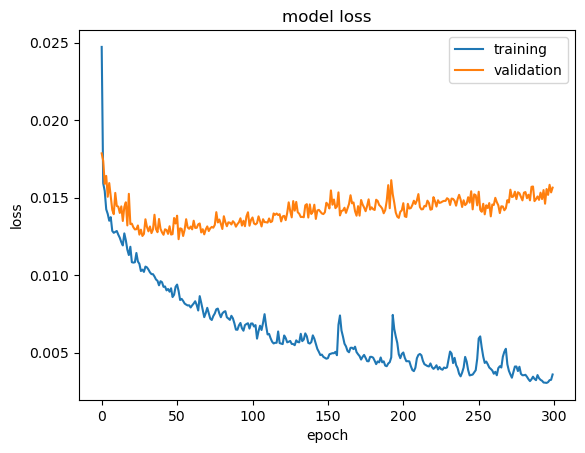

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

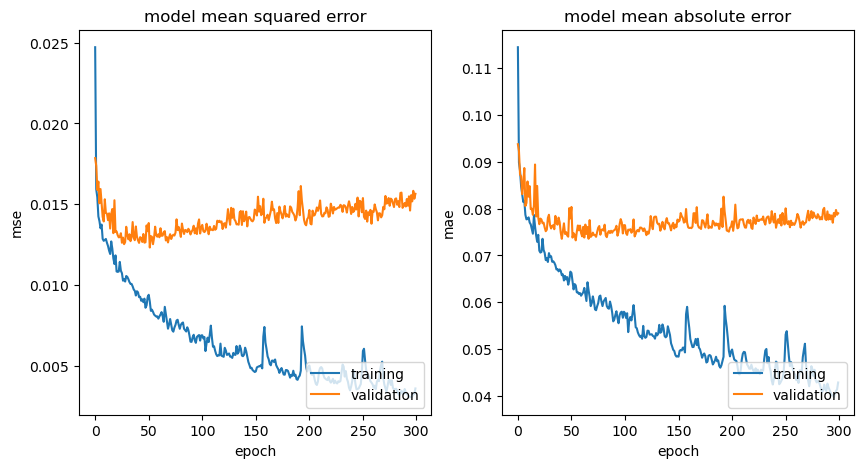

In [91]:
# summarize history for accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history.history['mse'])
ax1.plot(history.history['val_mse'])
ax1.set_title('model mean squared error')
ax1.set_ylabel('mse')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='lower right')

ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.set_title('model mean absolute error')
ax2.set_ylabel('mae')
ax2.set_xlabel('epoch')
ax2.legend(['training', 'validation'], loc='lower right')

In [93]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=8)
print(loss_and_metrics)

774/774 [==============================] - 0s 258us/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0775
[0.014341553673148155, 0.014341553673148155, 0.07752180099487305]


# Regularization

The training and validation loss function diverge during the training resulting in a considerably higher validation loss than the data. Can we use regularizer in order to control that?

## L1/L2 Regularizer

### Task 3: Train and evaluate the same DNN with an L2 Regularizer
* The regularizer can be simply set by importing `from keras.regularizers import l2` and adding `kernel_regularizer=l2(l2_lambda)` as option to the Dense layer
* Choose `l2_lambda=0.0001`
* Prepare the inputs the same way as before and perfom the same scaling
* How does the loss function evolution change?
* How does the performance and the prediction change?

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df.values, housing.target, test_size=0.3, random_state=42)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

In [95]:
from keras.regularizers import l2

l2_lambda= 0.0001
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=8, kernel_regularizer=l2(l2_lambda)))
model.add(Dense(units=64, activation='relu', input_dim=8, kernel_regularizer=l2(l2_lambda)))
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))


optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0015)
loss=tf.keras.losses.MeanSquaredError()
metrics=['mse', 'mae']


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [96]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=300, batch_size=256)

Epoch 1/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0462 - mse: 0.0326 - mae: 0.1370 - val_loss: 0.0337 - val_mse: 0.0210 - val_mae: 0.1038
Epoch 2/300
40/40 [==============================] - 0s 944us/step - loss: 0.0295 - mse: 0.0177 - mae: 0.0962 - val_loss: 0.0290 - val_mse: 0.0180 - val_mae: 0.0959
Epoch 3/300
40/40 [==============================] - 0s 960us/step - loss: 0.0268 - mse: 0.0163 - mae: 0.0917 - val_loss: 0.0271 - val_mse: 0.0172 - val_mae: 0.0913
Epoch 4/300
40/40 [==============================] - 0s 967us/step - loss: 0.0249 - mse: 0.0154 - mae: 0.0882 - val_loss: 0.0266 - val_mse: 0.0175 - val_mae: 0.0939
Epoch 5/300
40/40 [==============================] - 0s 976us/step - loss: 0.0241 - mse: 0.0154 - mae: 0.0881 - val_loss: 0.0248 - val_mse: 0.0165 - val_mae: 0.0891
Epoch 6/300
40/40 [==============================] - 0s 965us/step - loss: 0.0232 - mse: 0.0151 - mae: 0.0865 - val_loss: 0.0236 - val_mse: 0.0158 - val_mae: 0.0898
Epoch 7/300


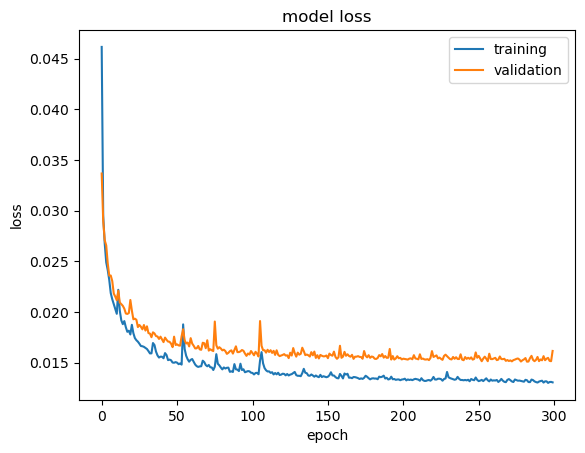

In [97]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

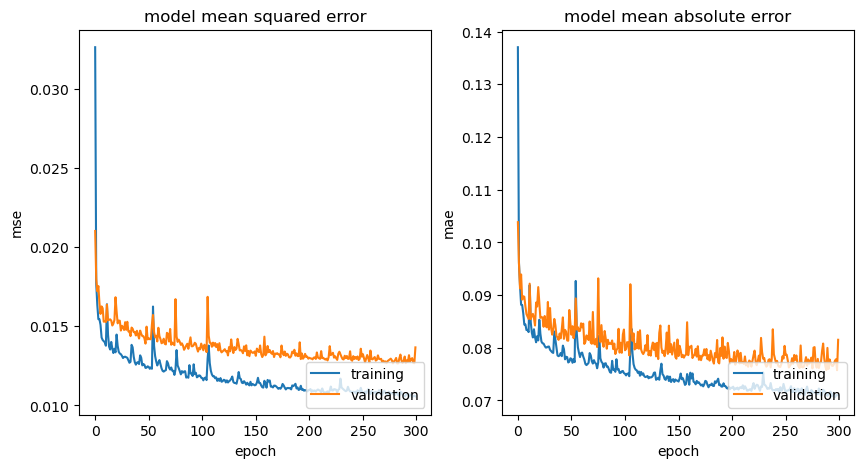

In [98]:
# summarize history for accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history.history['mse'])
ax1.plot(history.history['val_mse'])
ax1.set_title('model mean squared error')
ax1.set_ylabel('mse')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='lower right')

ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.set_title('model mean absolute error')
ax2.set_ylabel('mae')
ax2.set_xlabel('epoch')
ax2.legend(['training', 'validation'], loc='lower right')

Testing...
774/774 [==============================] - 0s 204us/step


(array([ 813., 1127., 1125.,  888.,  681.,  518.,  365.,  267.,  197.,
         211.]),
 array([0.09015982, 0.18098919, 0.27181858, 0.36264795, 0.45347732,
        0.5443067 , 0.63513607, 0.72596544, 0.81679481, 0.90762419,
        0.99845356]),
 <BarContainer object of 10 artists>)

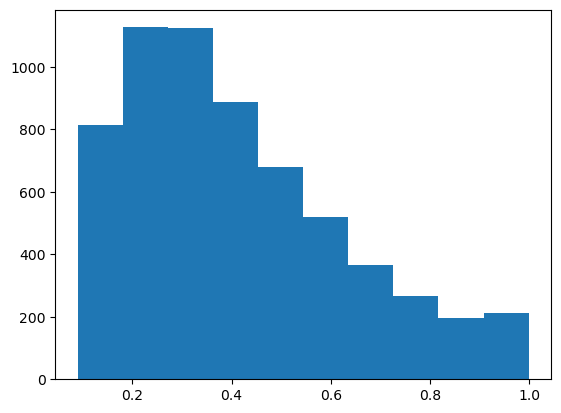

In [99]:
print('Testing...')
y_pred = model.predict(X_test, verbose = True, batch_size=8)
plt.hist(y_pred)

In [100]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Explained variance score: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))

Coefficient of determination: 0.77
Mean squared error: 0.01
Mean absolute error: 0.08


## Dropout

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.values, housing.target, test_size=0.3, random_state=42)

scaler = RobustScaler(quantile_range=(25, 75))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)
y_train

array([0.36866034, 0.31896982, 0.50474225, ..., 0.42701061, 0.55360803,
       0.63917468])

In [102]:
from tensorflow.keras.layers import Dropout # type: ignore
model = Sequential()
dropout=0.2
model.add(Dense(units=128, activation='relu', input_dim=8))
model.add(Dropout(dropout))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(units=8 , activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               1152      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 8)                

In [103]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=300, batch_size=256)

Epoch 1/300
40/40 [==============================] - 0s 3ms/step - loss: 0.0432 - mae: 0.1640 - val_loss: 0.0249 - val_mae: 0.1166
Epoch 2/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0289 - mae: 0.1293 - val_loss: 0.0205 - val_mae: 0.1074
Epoch 3/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0244 - mae: 0.1173 - val_loss: 0.0189 - val_mae: 0.0977
Epoch 4/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0220 - mae: 0.1102 - val_loss: 0.0178 - val_mae: 0.0941
Epoch 5/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0213 - mae: 0.1080 - val_loss: 0.0171 - val_mae: 0.0944
Epoch 6/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0201 - mae: 0.1043 - val_loss: 0.0168 - val_mae: 0.0914
Epoch 7/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0197 - mae: 0.1034 - val_loss: 0.0165 - val_mae: 0.0898
Epoch 8/300
40/40 [==============================] - 0s 1ms/step - loss: 0.0190 - m

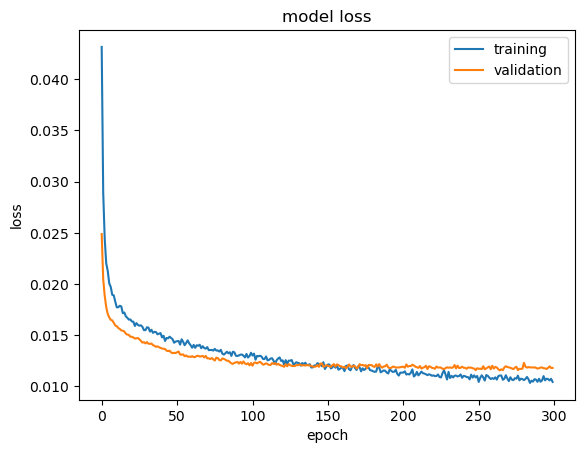

In [104]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

**You have to treat this result with care:** The training loss is evaluated after each batch, where nodes are dropped, while the validation loss is calculated after one epoch, where all nodes are included.

In [105]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=256)
print(loss_and_metrics)
y_pred = model.predict(X_test, verbose = True, batch_size=256)

25/25 [==============================] - 0s 450us/step - loss: 0.0115 - mae: 0.0693
[0.011493122205138206, 0.06933515518903732]
25/25 [==============================] - 0s 382us/step


In [106]:
# Explained variance score: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))

Coefficient of determination: 0.79
Mean squared error: 0.01
Mean absolute error: 0.07


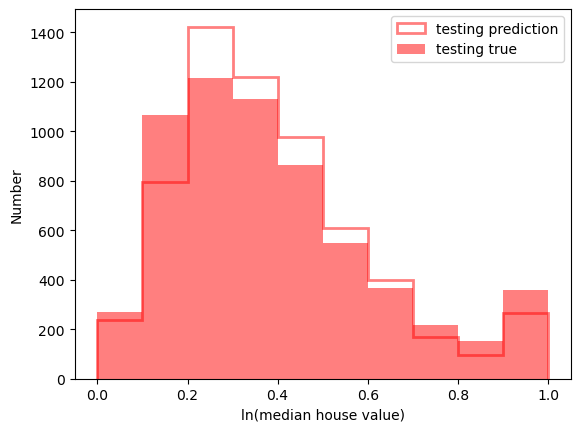

In [107]:
# predictions
y_pred.reshape(-1)

plt.hist(y_test, alpha=0.5, color='red', range=[0, 1], bins=10)
plt.hist(y_pred, alpha=0.5, color='red', range=[0, 1], bins=10, histtype='step', linewidth=2)
plt.xlabel('ln(median house value)')
plt.ylabel('Number')
plt.legend(['testing prediction', 'testing true'], loc='upper right')

## Task 4 (Bonus) - Playtime
* What do you need to change in the DNN if you don't scale the target vector?
* How does the result change if you use a quantile transformer with uniform output?
* How does the L1 regularizer perform?
* What happens if you change the L2 regularizer strength?
* What happens if you change the drop out percentage?
* How does the result change if you use only the 3 most important features?